# Calculate the AMOC in density space

$VVEL*DZT*DXT (x,y,z)$ -> $VVEL*DZT*DXT (x,y,$\sigma$)$ -> $\sum_{x=W}^E$ -> $\sum_{\sigma=\sigma_{max/min}}^\sigma$

In [1]:
import os
import sys
import xgcm
import numpy as np
import xarray as xr
import cmocean
import pop_tools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rc_file('rc_file_paper')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [3]:
from MOC import calculate_AMOC_sigma_z
from tqdm import notebook
from paths import path_results, path_prace, file_RMASK_ocn, file_RMASK_ocn_low, file_ex_ocn_ctrl, file_ex_ocn_lpd, path_data
from FW_plots import Atl_lats
from timeseries import lowpass
from xhistogram.xarray import histogram
from xr_DataArrays import xr_DZ_xgcm
from xr_regression import xr_lintrend, xr_linear_trend, xr_2D_trends, ocn_field_regression

In [4]:
RAPIDz = xr.open_dataarray(f'{path_data}/RAPID_AMOC/moc_vertical.nc')

In [5]:
kwargs = dict(combine='nested', concat_dim='time', decode_times=False)
ds_ctrl = xr.open_mfdataset(f'{path_prace}/MOC/AMOC_sz_yz_ctrl_*.nc', **kwargs)
ds_rcp  = xr.open_mfdataset(f'{path_prace}/MOC/AMOC_sz_yz_rcp_*.nc' , **kwargs)
ds_lpd  = xr.open_mfdataset(f'{path_prace}/MOC/AMOC_sz_yz_lpd_*.nc' , **kwargs)
ds_lr1  = xr.open_mfdataset(f'{path_prace}/MOC/AMOC_sz_yz_lr1_*.nc' , **kwargs)

In [6]:
AMOC_ctrl = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_ctrl.nc', decode_times=False)
AMOC_rcp  = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_rcp.nc' , decode_times=False)
AMOC_lpd  = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_lpd.nc' , decode_times=False)
AMOC_lr1  = xr.open_dataarray(f'{path_results}/MOC/AMOC_max_lr1.nc' , decode_times=False)

Text(-0.1, -0.1, '[Sv/100yr]')

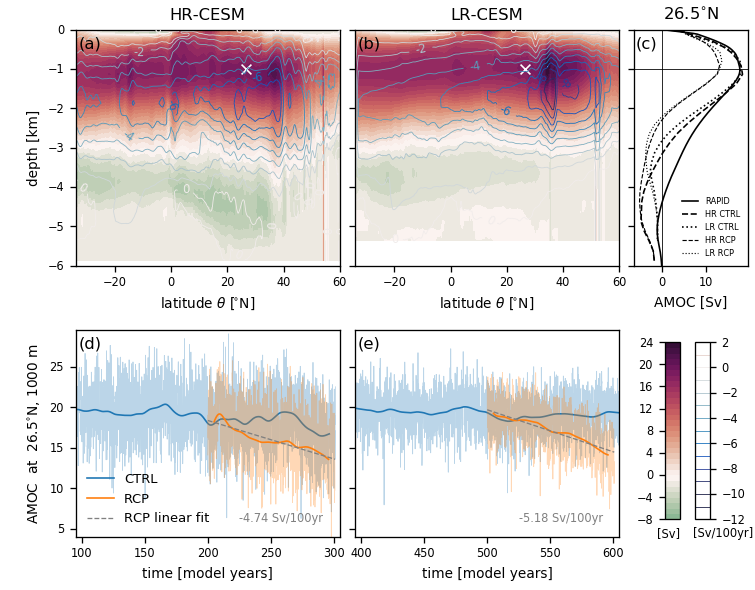

In [7]:
mycmap = cmocean.tools.crop_by_percent(cmocean.cm.curl, 100/3, which='min', N=None)
f = plt.figure(figsize=(6.4,5))

# profiles
ax = f.add_axes([.84,.55,.15,.4])
ax.set_title(r'26.5$\!^\circ\!$N')
ax.set_ylim((-6,0))
ax.set_yticklabels([])
ax.axvline(0, c='k', lw=.5)
ax.axhline(-1, c='k', lw=.5)
r, = ax.plot(RAPIDz.mean('time'), -RAPIDz.depth/1e3, c='k', label='RAPID')
RAPID_ctrl = ds_ctrl['AMOC(y,z)'].isel(nlat_u=1456).mean('time')
RAPID_lpd  = ds_lpd ['AMOC(y,z)'].isel(nlat_u= 271).mean('time')
RAPID_rcp = 365*100*xr_linear_trend(ds_rcp['AMOC(y,z)'].isel(nlat_u=1456)).rename({'dim_0':'z_t'}).assign_coords(z_t=ds_rcp.z_t) + RAPID_ctrl
RAPID_lr1 = 365*100*xr_linear_trend(ds_lr1['AMOC(y,z)'].isel(nlat_u= 271)).rename({'dim_0':'z_t'}).assign_coords(z_t=ds_lr1.z_t) + RAPID_lpd 
hc, = ax.plot(RAPID_ctrl, -ds_ctrl.z_t/1e5, c='k', ls='--', label='HR CTRL')
lc, = ax.plot(RAPID_lpd , -ds_lpd .z_t/1e5, c='k', ls=':' , label='LR CTRL')
hr, = ax.plot(RAPID_rcp , -ds_ctrl.z_t/1e5, c='k', ls='--', lw=.7, label='HR RCP')
lr, = ax.plot(RAPID_lr1 , -ds_lpd .z_t/1e5, c='k', ls=':' , lw=.7, label='LR RCP')
ax.text(.01,.92, '(c)', transform=ax.transAxes)
ax.set_xlabel('AMOC [Sv]')
ax.legend(handles=[r, hc, lc, hr, lr], fontsize=5, frameon=False, handlelength=2, loc='lower right')

for i, sim in enumerate(['HIGH', 'LOW']):
    axt = f.add_axes([.1+i*.37,.55,.35,.4])
    axb = f.add_axes([.1+i*.37,.09,.35,.35])
    
    # psi
    axt.set_title(['HR-CESM', 'LR-CESM'][i])
    axt.set_ylim((-6,0))
    axt.set_xlim((-34,60))
    if i==0:
        axt.set_ylabel('depth [km]')
        axb.set_ylabel('AMOC  at  26.5$\!^\circ\!$N, 1000 m')
    else:
        axt.set_yticklabels([])
        axb.set_yticklabels([])
        
    (ds_mean, ds_trend) = [(ds_ctrl, ds_rcp), (ds_lpd, ds_lr1)][i]
    vmaxm = 25
    vmaxt = 10
    mean = ds_mean['AMOC(y,z)'].mean('time')
    trend = xr_2D_trends(ds_trend['AMOC(y,z)']).rolling(nlat_u=[15,3][i]).mean()*100*365
    Xm,Ym = np.meshgrid(Atl_lats(sim=sim), -1e-5*mean['z_t'].values)
    Xt,Yt = np.meshgrid(Atl_lats(sim=sim), -1e-5*trend['z_t'].values)
    im = axt.contourf(Xm, Ym, mean, cmap=mycmap, levels=np.arange(-8,25,1))
    cs = axt.contour(Xm, Ym, trend, levels=np.arange(-12,3,1),
                     cmap='cmo.balance', vmin=-10, vmax=10, linewidths=.5)
    axt.clabel(cs, np.arange(-12,3,2), fmt='%d', fontsize=7)
    axt.text(.01,.92, '('+['a','b'][i]+')', transform=axt.transAxes)
    axt.scatter(26.5,-1, color='w', marker='x')
    
    axt.set_xlabel(r'latitude $\theta$ [$\!^{\!\circ}\!$N]')
    
    # time series
    AMOC_c = [AMOC_ctrl, AMOC_lpd][i]
    AMOC_r = [AMOC_rcp , AMOC_lr1][i]

    axb.set_xlabel('time [model years]')
    axb.plot(AMOC_c.time/365, AMOC_c, c='C0', alpha=.3, lw=.5)
    axb.plot(AMOC_c.time[60:-60]/365, lowpass(AMOC_c,120)[60:-60], c='C0', label='CTRL')
    
    axb.plot(AMOC_r.time/365-[1800,1500][i], AMOC_r, c='C1', alpha=.3, lw=.5)
    axb.plot(AMOC_r.time[60:-60]/365-[1800,1500][i], lowpass(AMOC_r,120)[60:-60], c='C1', label='RCP')
    axb.plot(AMOC_r.time/365-[1800,1500][i], xr_lintrend(AMOC_r), c='grey', lw=.8, ls='--', label='RCP linear fit')
    axb.text(25+[200,500][i], 5.8, f'{xr_linear_trend(AMOC_r).values*100*365:3.2f} Sv/100yr', color='grey', fontsize=7)

    axb.set_ylim((4,29.5))
    if i==0:
        axb.legend(frameon=False, fontsize=8)
    axb.set_xlim([(95,305), (395,605)][i])
    axb.text(.01,.91, '('+['d','e'][i]+')', transform=axb.transAxes)
    
cax1 = f.add_axes([.88,.12,.02,.3])
f.colorbar(im, cax=cax1)
cax1.text(1,-.1,'[Sv]', ha='right', fontsize=7, transform=cax1.transAxes)
cax1.yaxis.set_ticks_position('left')

cax2 = f.add_axes([.92,.12,.02,.3])
f.colorbar(cs, cax=cax2)
cax2.text(-.1,-.1,'[Sv/100yr]', ha='left', fontsize=7, transform=cax2.transAxes)
# plt.savefig(f'{path_results}/FW-paper/Fig5', dpi=600)